# Importing module

In [2]:
import os
import math
import random
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import models, transforms, datasets
from torchvision.transforms import ToTensor, Compose, Normalize, Lambda
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
from timm.models.vision_transformer import Block
from timm.layers import trunc_normal_
from skimage.metrics import structural_similarity as ssim
import cv2
import torch.nn.functional as F

# Checking for cuda

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
from pathlib import Path
image_path = Path("/kaggle/input/gsoc-6b-foundation-models")
LR_path = Path('/kaggle/input/gsoc-6b-foundation-models/Dataset/LR')
HR_path = Path('/kaggle/input/gsoc-6b-foundation-models/Dataset/HR')

# Plotting raw images of data folder

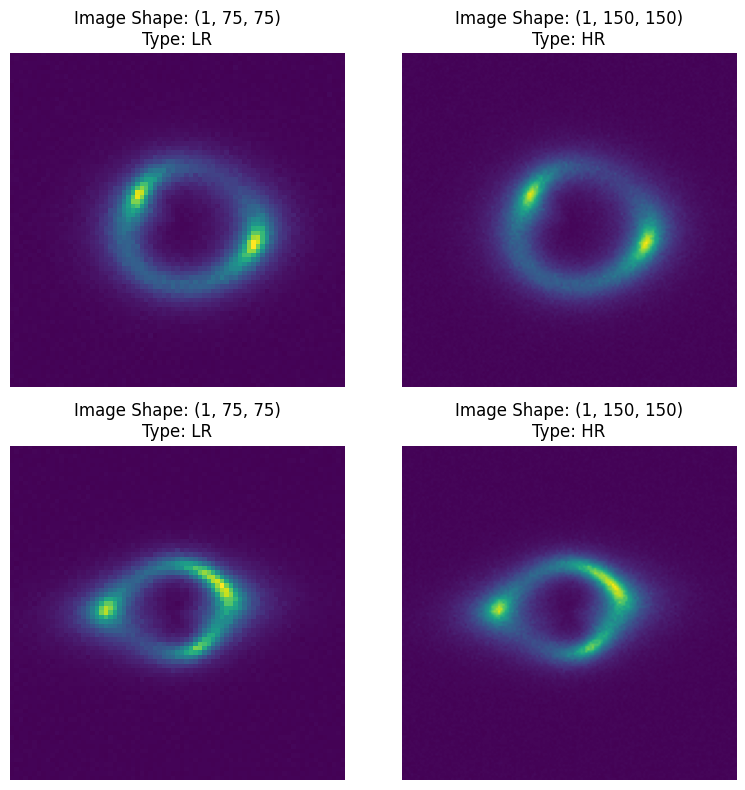

In [4]:
n = 2
LR_path_list = list(LR_path.glob("*.npy"))
random_lr_paths = random.sample(LR_path_list, n)

fig, ax = plt.subplots(n, 2, figsize=(8, 4 * n))

for row, lr_path in enumerate(random_lr_paths):
    hr_path = HR_path / lr_path.name

    for col, img_path in enumerate([lr_path, hr_path]):
        img = np.load(img_path)
        img_tensor = torch.tensor(img)
        if img_tensor.ndim == 3:
            img_tensor = img_tensor.permute(1, 2, 0)

        ax[row, col].imshow(img_tensor)
        ax[row, col].set_title(f"Image Shape: {img.shape}\nType: {img_path.parent.stem}")
        ax[row, col].axis("off")
plt.tight_layout()
plt.show()



# Creating custom data pipeline

In [5]:
class NumpyDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None):
        self.data_path = data_path
        self.transform = transform
        self.target_transform = target_transform
        self.file_paths = list((self.data_path / "LR").glob("*.npy"))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        LR = np.load(file_path)
        HR = np.load(self.data_path / "HR" / file_path.name)
        if self.transform:
            LR = self.transform(LR)
        if self.target_transform:
            HR = self.target_transform(HR)
        return LR, HR

## Transform for data augmentation

In [6]:
transform = transforms.Compose([
    lambda x: torch.from_numpy(x).float(), 
    transforms.Resize((64, 64))
])

target_transform = transforms.Compose([
    lambda x: torch.from_numpy(x).float(), 
])


## Loading dataset

In [7]:
train_dir = image_path/"Dataset"
data = NumpyDataset(train_dir,transform = transform, target_transform=target_transform)

## Displaying random transformed images from dataset

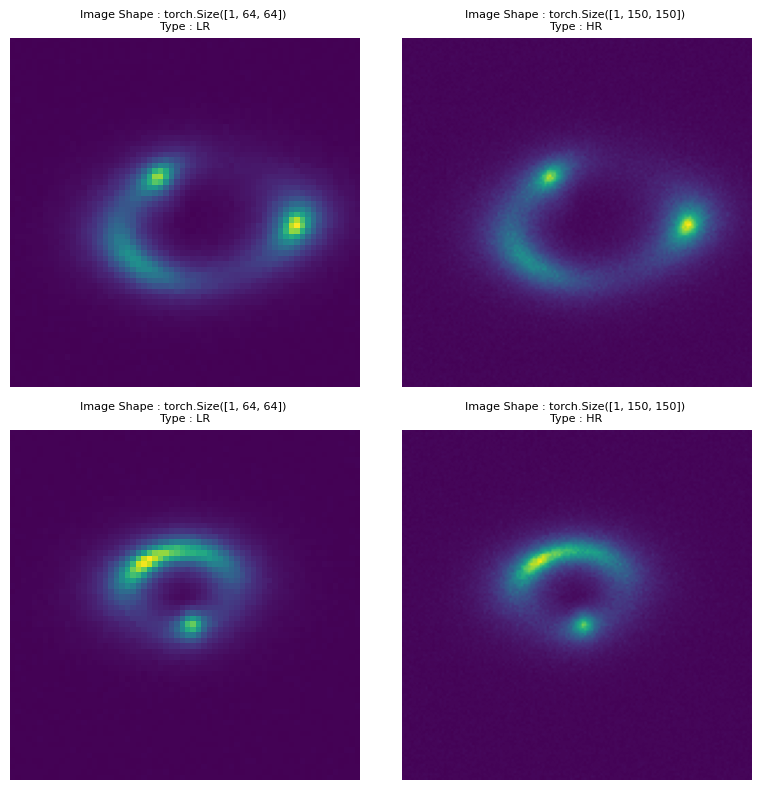

In [8]:
def display_random_images(dataset,n,seed=None):
    if n>10:
        n=10
    if seed:
        torch.manual_seed(seed)
    random_samples_idx = random.sample(range(len(dataset.file_paths)),n)   
    fig, ax = plt.subplots(n, 2, figsize=(8, 4 * n))
    for row, idx in enumerate(random_samples_idx):
        LR, HR = dataset[idx]
        for col, img in enumerate([LR, HR]):
            cat = "LR" if col==0 else "HR"
            ax[row, col].imshow(img.permute(1,2,0))
            ax[row, col].set_title(f"Image Shape : {img.shape} \nType : {cat}", fontsize=8)
            ax[row, col].axis("off")
    plt.tight_layout()
    plt.show()
display_random_images(data,2,seed=None)

# **ViT-MAE** Model

In [9]:
def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))
    
class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio    
    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))
        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)    
        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]
        return patches, forward_indexes, backward_indexes
        
class MAE_Encoder(torch.nn.Module):
    def __init__(self,image_size=64,patch_size=2,emb_dim=192,num_layer=12,num_head=3,mask_ratio=0.75) -> None:
        super().__init__()
        self.emb_dim = emb_dim
        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)
        self.patchify = torch.nn.Conv2d(1, emb_dim, patch_size, patch_size)
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])
        self.layer_norm = torch.nn.LayerNorm(emb_dim)
        self.init_weight()
    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)
    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches, forward_indexes, backward_indexes = self.shuffle(patches)
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,image_size=32,patch_size=2,emb_dim=192,num_layer=4,num_head=3) -> None:
        super().__init__()
        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])
        self.head = torch.nn.Linear(emb_dim, 1 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)
        self.init_weight()
    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)
    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding
        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:]
        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)
        return img, mask
        
class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=64,
                 patch_size=16,
                 emb_dim=256,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()
        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)
    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

# **Model to upscale low resolution image to high resolution**

In [10]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (scale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        return self.act(x)

class MAE_HR_ViT(nn.Module):
    def __init__(self, mae_encoder, input_dim=768, emb_dim=256, patch_size=16, num_layers=2, num_heads=8, num_upsample_blocks=3):
        super().__init__() 
        self.encoder = mae_encoder
        self.cls_token = self.encoder.cls_token
        self.pos_embedding = self.encoder.pos_embedding
        self.patchify = self.encoder.patchify
        self.transformer = self.encoder.transformer
        self.layer_norm = self.encoder.layer_norm

        self.feature_proj = nn.Conv1d(input_dim, 256, kernel_size=1)  
        
        self.upsample_blocks = nn.Sequential(
            *[UpsampleBlock(256, 256) for _ in range(num_upsample_blocks)],
            nn.Conv2d(256, 1, kernel_size=3, padding=1),  # Final output to 1-channel image
            nn.Tanh()  # Normalize output between -1 and 1 (for image scaling)
        )

        self.interpolate = lambda x: F.interpolate(x, size=(150, 150), mode='bilinear', align_corners=False)

    def forward(self, x):
        patches = self.patchify(x)
        patches = rearrange(patches, 'b c h w -> (h w) b c')        
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)        
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))        
        encoded_features = rearrange(features, 'b t c -> b c t')[:, :, 1:]  # Remove CLS token
        
        encoded_features = self.feature_proj(encoded_features)  # Project to 256 channels
        encoded_features = encoded_features.view(-1, 256, 4, 4)  # Reshape to 4x4 spatial
        
        reconstructed_img = self.upsample_blocks(encoded_features)
        reconstructed_img = self.interpolate(reconstructed_img) 
        
        return reconstructed_img


### Loading pretrained weights of ViT-MAE model on dataset of Task 6A and Creating instance for upscale model from encoder of ViT-MAE model

In [11]:
from torchinfo import summary
mae_model = MAE_ViT(image_size=64,
                 patch_size=16,
                 emb_dim=768,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=0.75).to(device)

mae_model.load_state_dict(torch.load("/kaggle/input/vit-mae-wt/pytorch/default/1/vit-mae-wt.pth", map_location =device, weights_only = True))
model_sr_1 = MAE_HR_ViT(mae_model.encoder).to(device)

model_summary = summary(
    model_sr_1,
    input_size=(1, 1, 64,64),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"])
model_summary

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MAE_HR_ViT (MAE_HR_ViT)                       [1, 1, 64, 64]       [1, 1, 150, 150]     13,056               True
├─Conv2d (patchify)                           [1, 1, 64, 64]       [1, 768, 4, 4]       197,376              True
├─Sequential (transformer)                    [1, 17, 768]         [1, 17, 768]         --                   True
│    └─Block (0)                              [1, 17, 768]         [1, 17, 768]         --                   True
│    │    └─LayerNorm (norm1)                 [1, 17, 768]         [1, 17, 768]         1,536                True
│    │    └─Attention (attn)                  [1, 17, 768]         [1, 17, 768]         2,360,064            True
│    │    └─Identity (ls1)                    [1, 17, 768]         [1, 17, 768]         --                   --
│    │    └─Identity (drop_path1)             [1, 17, 768]         [1, 17, 768]      

# Optimizer and Scheduler

In [12]:
import torch.optim as optim
loss_fn = nn.MSELoss()

BASE_LR = 5e-4
optimizer = torch.optim.AdamW(model_sr_1.parameters(), lr=BASE_LR, betas=(0.9, 0.95), weight_decay=0.02)

lr_func = lambda epoch: min((epoch + 1) / (10 + 1e-8), 0.5 * (math.cos(epoch / 50 * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func)

### Train Step

In [13]:
def train_step(model, dataloader, loss_fn, optimizer, device,epoch,epochs):
    model.to(device)
    model.train()
    total_loss = 0
    for lr_imgs, hr_imgs in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)
        loss = loss_fn(sr_imgs, hr_imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [14]:
def compute_psnr(img1, img2, max_value=1.0):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    psnr = 10 * np.log10((max_value ** 2) / mse)
    return psnr

### Test step

In [15]:
def validate_step(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, mse_vals, ssim_vals, psnr_vals = 0, [], [], []
    with torch.no_grad():
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            loss = loss_fn(sr_imgs, hr_imgs)
            total_loss += loss.item()
            mse_vals.append(F.mse_loss(sr_imgs, hr_imgs).item())
            ssim_vals.append(ssim(hr_imgs.cpu().numpy()[0, 0], sr_imgs.cpu().numpy()[0, 0], data_range=1.0))
            psnr_vals.append(compute_psnr(hr_imgs.cpu().numpy(), sr_imgs.cpu().numpy()))
    return total_loss / len(dataloader), np.mean(mse_vals), np.mean(ssim_vals), np.mean(psnr_vals)

### Training loop for model 

In [16]:
def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, epochs,lr_scheduler, model_path):
    train_losses, val_losses, ssim_scores, psnr_scores = [], [], [], []
    best_psnr = 0
    for epoch in range(epochs):
        train_loss = train_step(model, train_dataloader, loss_fn, optimizer, device, epoch, epochs)
        lr_scheduler.step()
        val_loss, mse, ssim_val, psnr_val = validate_step(model, val_dataloader, loss_fn, device)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, MSE={mse:.4f}, SSIM={ssim_val:.4f}, PSNR={psnr_val:.4f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        ssim_scores.append(ssim_val)
        psnr_scores.append(psnr_val)
        if psnr_val > best_psnr:
            best_psnr = psnr_val
            torch.save(model.state_dict(), model_path)
    return train_losses, val_losses, ssim_scores, psnr_scores

### Creating 90:10 split train-test split and creating dataloader for each

In [17]:
EPOCHS = 10
BATCH_SIZE = 256

train_size = int(0.9 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
train_losses, val_losses, ssim_scores, psnr_scores = train(model_sr_1, 
                                                           train_dataloader, 
                                                           test_dataloader, 
                                                           loss_fn, 
                                                           optimizer, 
                                                           device, 
                                                           epochs=EPOCHS,
                                                           lr_scheduler= lr_scheduler, 
                                                           model_path="SR_wt.pth")

Epoch 1/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.0089, Val Loss=0.0065, MSE=0.0065, SSIM=0.6771, PSNR=21.8995


Epoch 2/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.0046, Val Loss=0.0026, MSE=0.0026, SSIM=0.7039, PSNR=25.9077


Epoch 3/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.0016, Val Loss=0.0010, MSE=0.0010, SSIM=0.8830, PSNR=29.9036


Epoch 4/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.0011, Val Loss=0.0007, MSE=0.0007, SSIM=0.9116, PSNR=31.7459


Epoch 5/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.0007, Val Loss=0.0004, MSE=0.0004, SSIM=0.9327, PSNR=33.4797


Epoch 6/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.0005, Val Loss=0.0004, MSE=0.0004, SSIM=0.9424, PSNR=33.7862


Epoch 7/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.0005, Val Loss=0.0004, MSE=0.0004, SSIM=0.9407, PSNR=33.7220


Epoch 8/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.0004, Val Loss=0.0004, MSE=0.0004, SSIM=0.9416, PSNR=34.0809


Epoch 9/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.0004, Val Loss=0.0007, MSE=0.0007, SSIM=0.9127, PSNR=31.6805


Epoch 10/10:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.0004, Val Loss=0.0003, MSE=0.0003, SSIM=0.9549, PSNR=35.8112


# Plotting metrics for MSE, SSIM, PSNR

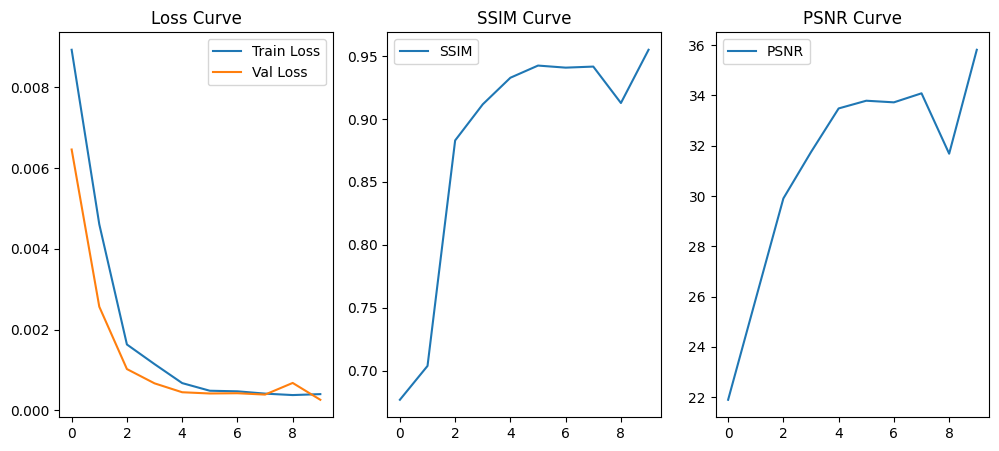

In [19]:
def plot_metrics(train_losses, val_losses, ssim_scores, psnr_scores):
    epochs = range(len(train_losses))
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.subplot(1, 3, 2)
    plt.plot(epochs, ssim_scores, label="SSIM")
    plt.legend()
    plt.title("SSIM Curve")
    plt.subplot(1, 3, 3)
    plt.plot(epochs, psnr_scores, label="PSNR")
    plt.legend()
    plt.title("PSNR Curve")
    plt.show()
plot_metrics(train_losses, val_losses, ssim_scores, psnr_scores)

# Comparing input, upscaled and ground truth images

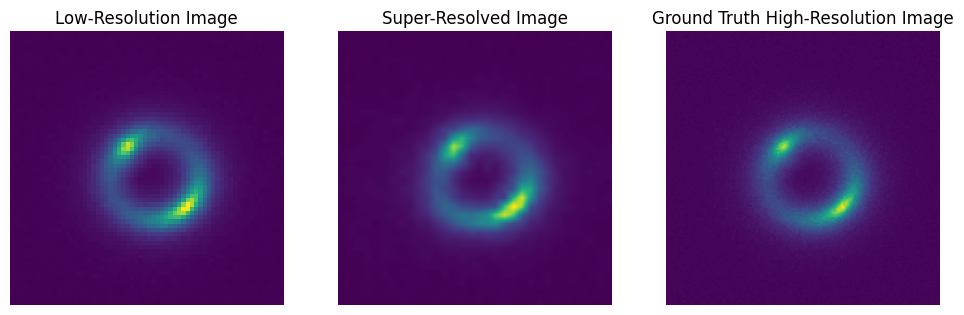

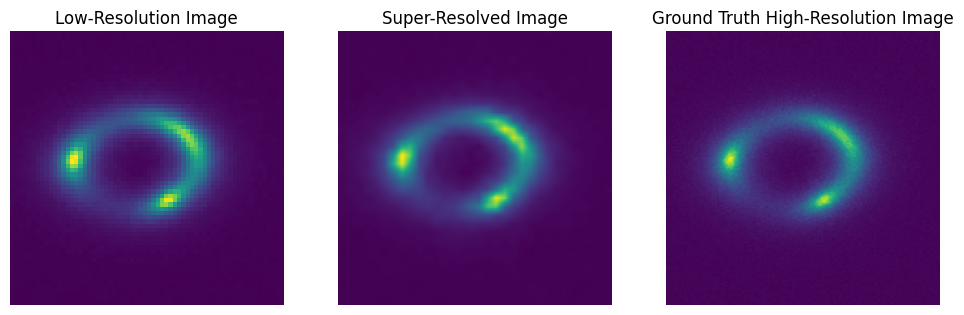

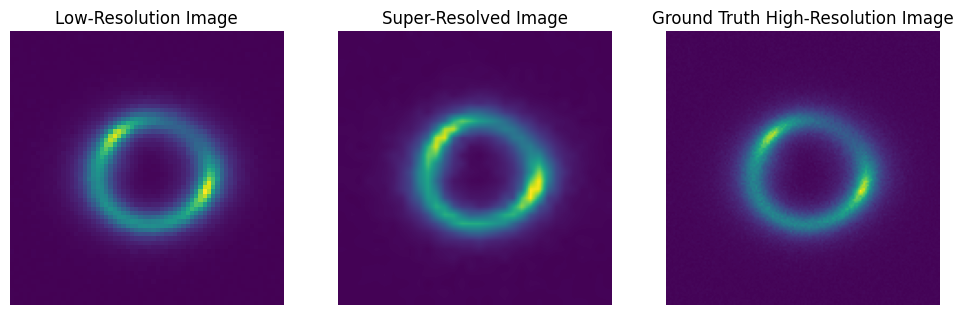

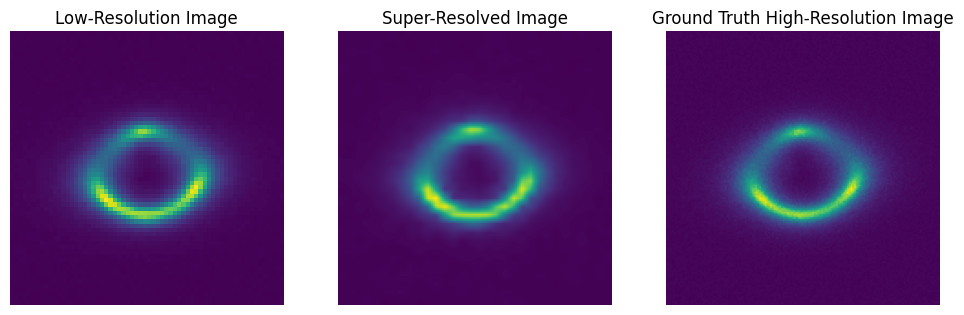

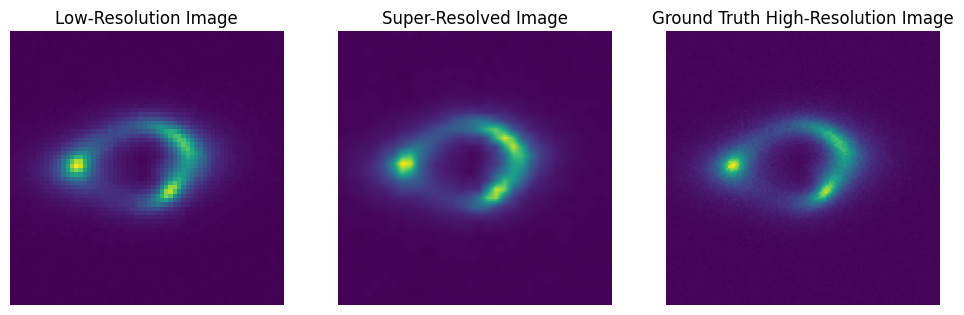

In [20]:
def compare_images(model, dataset, device,n):
    model.eval()
    index = np.random.choice(len(dataset),n)
    for idx in index:
        lr_img, hr_img = dataset[idx]
        lr_img, hr_img = lr_img.unsqueeze(0).to(device), hr_img.numpy()
        with torch.no_grad():
            sr_img = model(lr_img).cpu().numpy()[0, 0]
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(lr_img.cpu().numpy()[0, 0])
        plt.title(f"Low-Resolution Image")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(sr_img)
        plt.title(f"Super-Resolved Image")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(hr_img.squeeze())
        plt.title(f"Ground Truth High-Resolution Image")
        plt.axis("off")
        plt.show()
compare_images(model_sr_1, test_dataset, device,n=5)